IMPORT LIBRARIES

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

CHECK THE DEVICE

In [2]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


cpu


IMPORT THE DATASET

In [3]:
# Folder path
dataset_folder = 'dataset'
img_size = (64, 64)  # Resize images to 128 x 128

def load_images_and_labels(dataset_folder, img_size):
    images = []
    labels = []
    
    #iterate on the folders  
    for label_folder in os.listdir(dataset_folder):
        #take the name of the inside folder
        label_path = os.path.join(dataset_folder, label_folder)
        if os.path.isdir(label_path):
            label = label_folder  # Using folder names as labels
            
            #for each image in the folder
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                
                img = cv2.imread(img_path)
                if img is not None:  # Check if image is read successfully
                    
                    #convert to grey scale
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    #resize the image
                    img = cv2.resize(img, img_size)
                    #extract a vector
                    img = img.flatten()
                    images.append(img)
                    
                    labels.append(label)
    
    #return all the images and the labels
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(dataset_folder, img_size)

#divide the images and the labels into train and test (80%, 20%)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=25)

# Create a summary dataframe
unique_labels, counts = np.unique(labels, return_counts=True)
summary_df = pd.DataFrame({
    'Label': unique_labels,
    'Number of Images': counts
})

# Display the summary dataframe
print("Dataset Summary:")
print(summary_df)

# Optionally, display the dataset shape and split information
print("\nTotal images:", len(images))
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


# Convert labels to numerical indices
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
y_train = np.array([label_to_index[label] for label in y_train])
y_test = np.array([label_to_index[label] for label in y_test])


Dataset Summary:
   Label  Number of Images
0   Bike               484
1    Car               506
2  Truck               391

Total images: 1381
Training set size: 1104
Testing set size: 277


In [4]:
# Check the dataset
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"Training set distribution: {class_distribution}")

Training set distribution: {0: 390, 1: 407, 2: 307}


CREATE DATA LOADER

In [5]:
# Function to create data loader
def create_data_loader(X, y, batch_size=32):
    #converted into tensors
    tensor_x = torch.Tensor(X)
    tensor_y = torch.LongTensor(y)
    #create dataset from tensors 
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Creating data loaders
train_loader = create_data_loader(X_train, y_train)
test_loader = create_data_loader(X_test, y_test)


FEED FORWARD NEURAL NETWORK

In [6]:
#Feed-forward multi-layer perceptron
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.dropout3(out)

        out = self.fc4(out)
        return out

CONVOLUTIONAL NEURAL NETWORK

In [7]:
#Convolutional neural network with 2 con layer, batch norm, relu and maxpool
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(64 * 16 * 16, 256)  # Adjust based on input image size
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Aggiungi reshaping all'inizio del metodo forward
        x = x.view(x.size(0), 1, 64, 64)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        
        out = out.view(out.size(0), -1)  # Flatten the tensor
        
        out = self.fc1(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        return out

EVALUATION DURING TRAINING

In [8]:
def evaluate_model(model, tasks):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for _ , test_loader in tasks:
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = nn.CrossEntropyLoss()(preds, y)
                val_loss += loss.item()
                correct += (preds.argmax(dim=1) == y).sum().item()
                total += y.size(0)
    model.train()
    return val_loss / len(tasks), correct / total

MAML ALGORITHM

In [9]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 5))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot([acc * 100 for acc in train_accuracies], label='Training Accuracy (%)')
    plt.plot([acc * 100 for acc in val_accuracies], label='Validation Accuracy (%)')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

def maml_train(model, meta_optimizer, tasks, num_iterations=1000, num_inner_steps=5, inner_lr=0.01):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for iteration in range(num_iterations):
        
        #set to zero the gradients of the meta optimizer
        meta_optimizer.zero_grad()
        
        meta_loss = 0
        total_correct = 0
        total_samples = 0

        for i, (train_loader, test_loader) in enumerate(tasks):
            
            #clone the weights in order to adapt the general parameters of the model to the new task
            fast_weights = [w.clone() for w in model.parameters()]
            
            for step in range(num_inner_steps):
                
                #iterate over the batches in the train loader
                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    
                    #computer the prediction
                    preds = model(x)
                    
                    #the crossentropyloss between prediction and ground truth
                    loss = nn.CrossEntropyLoss()(preds, y)
                    
                    #compute the gradient with respect to fast_weights, create_graph to computer next order gradient, unused to not consider useless weights
                    grads = torch.autograd.grad(loss, fast_weights, create_graph=True, allow_unused=True)
                    
                    #update inner adapted gradient
                    #θ0i = θ − α∇θLTi(fθ)
                    fast_weights = [w - inner_lr * g if g is not None else w for w, g in zip(fast_weights, grads)]
                    
                    total_correct += (preds.argmax(dim=1) == y).sum().item()
                    total_samples += y.size(0)
                    
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                
                #prediction on test
                preds = model(x)
                
                #loss on test
                loss = nn.CrossEntropyLoss()(preds, y)
                
                #total loss
                meta_loss += loss

        #compute the original gradients of the model 
        meta_loss.backward()
        
        #update the gradients
        #θ ← θ − β∇θXTi∼p(T )LTi(fθ0i) 
        meta_optimizer.step()

        # Logging training loss and accuracy
        train_losses.append(meta_loss.item())
        train_accuracy = total_correct / total_samples
        train_accuracies.append(train_accuracy)

        # Validation
        val_loss, val_acc = evaluate_model(model, tasks)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Iteration [{iteration+1}/{num_iterations}] completed, "
              f"Average Training Loss: {meta_loss.item():.4f}, "
              f"Training Accuracy: {train_accuracy:.4f}, "
              f"Average Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_acc:.4f}")

        torch.save(model.state_dict(), 'model_CNN_during_training.pth')
    # Plot metrics after training
    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

CREATION OF TASKS

In [10]:
# Encode the string labels to integers
label_encoder = LabelEncoder()
#convert the string label into int label
labels_encoded = label_encoder.fit_transform(labels)

def create_tasks(X, y, num_tasks=10, task_split=0.8):
    tasks = []
    for _ in range(num_tasks):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=task_split)
        train_loader = create_data_loader(X_train, y_train)
        test_loader = create_data_loader(X_test, y_test)
        tasks.append((train_loader, test_loader))
    return tasks

tasks = create_tasks(X_train, y_train)

In [11]:
model_CNN = SimpleCNN(3)
model_CNN.load_state_dict(torch.load('model_CNN_50_epochs.pth'))

<All keys matched successfully>

In [12]:
model_NN = NeuralNetwork(64 * 64, 3)
model_NN.load_state_dict(torch.load('model_NeuralNetwork_50_epochs.pth'))

<All keys matched successfully>

TRAINING PHASE

Iteration [1/50] completed, Average Training Loss: 5.6659, Training Accuracy: 0.9998, Average Validation Loss: 35.2102, Validation Accuracy: 0.6627
Iteration [2/50] completed, Average Training Loss: 127.8223, Training Accuracy: 0.8602, Average Validation Loss: 40.0122, Validation Accuracy: 0.4973
Iteration [3/50] completed, Average Training Loss: 31.7396, Training Accuracy: 0.9631, Average Validation Loss: 12.9206, Validation Accuracy: 0.8035
Iteration [4/50] completed, Average Training Loss: 61.1754, Training Accuracy: 0.9271, Average Validation Loss: 5.1561, Validation Accuracy: 0.9380
Iteration [5/50] completed, Average Training Loss: 40.6916, Training Accuracy: 0.9555, Average Validation Loss: 2.7136, Validation Accuracy: 0.9706
Iteration [6/50] completed, Average Training Loss: 26.2422, Training Accuracy: 0.9740, Average Validation Loss: 2.1113, Validation Accuracy: 0.9835
Iteration [7/50] completed, Average Training Loss: 23.3628, Training Accuracy: 0.9805, Average Validation Los

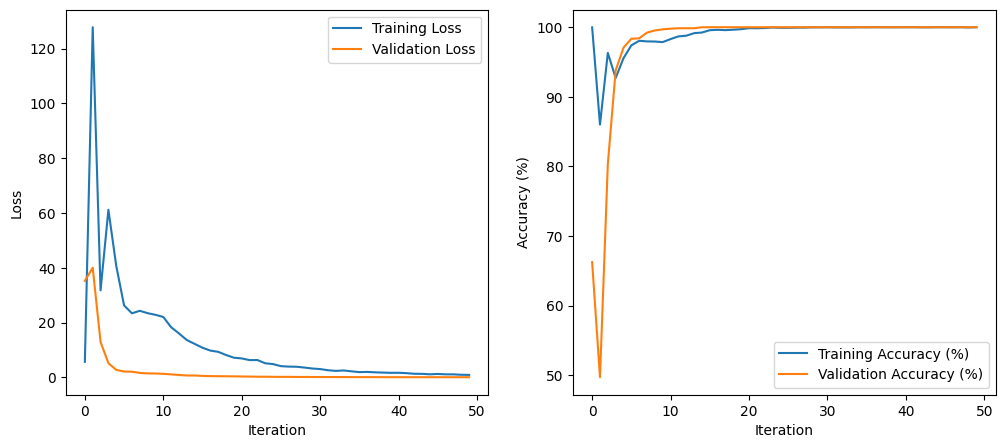

In [30]:
input_size = 64 * 64
num_classes = 3
#model = NeuralNetwork(input_size, num_classes)
#model = SimpleCNN(num_classes)

meta_optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)

# Train using MAML
maml_train(model_CNN, meta_optimizer, tasks, num_iterations=50)

ADAPTATION AND EVALUATION OF THE PERFORMANCE OF THE NEURAL NETWORK

In [13]:
# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def adapt_and_evaluate(model, train_loader, test_loader, num_inner_steps=5, inner_lr=0.01):
    model.to(device)
    
    #clone the weights of the model
    fast_weights = [w.clone() for w in model.parameters()]
    
    #the model adapts to the training data
    for step in range(num_inner_steps):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = nn.CrossEntropyLoss()(preds, y)
            grads = torch.autograd.grad(loss, fast_weights, allow_unused=True)
            fast_weights = [w - inner_lr * g if g is not None else w for w, g in zip(fast_weights, grads)]
    
    all_preds = []
    all_labels = []
    
    #evaluation of the model on the testing data with the adapted gradients
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        all_preds.extend(preds.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())
    
    label_names = label_encoder.classes_  # Using the label encoder to get the correct label names
    print(classification_report(all_labels, all_preds, target_names=label_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy
    accuracy = (np.trace(cm) / float(np.sum(cm))) * 100
    print(f'Accuracy: {accuracy:.2f}%')

    # Print total labels of each class
    total_labels = dict(zip(label_names, np.sum(cm, axis=1)))
    print(f'Total labels of each class: {total_labels}')


              precision    recall  f1-score   support

        Bike       0.89      0.90      0.90        94
         Car       0.89      0.84      0.86        99
       Truck       0.88      0.93      0.90        84

    accuracy                           0.89       277
   macro avg       0.89      0.89      0.89       277
weighted avg       0.89      0.89      0.89       277



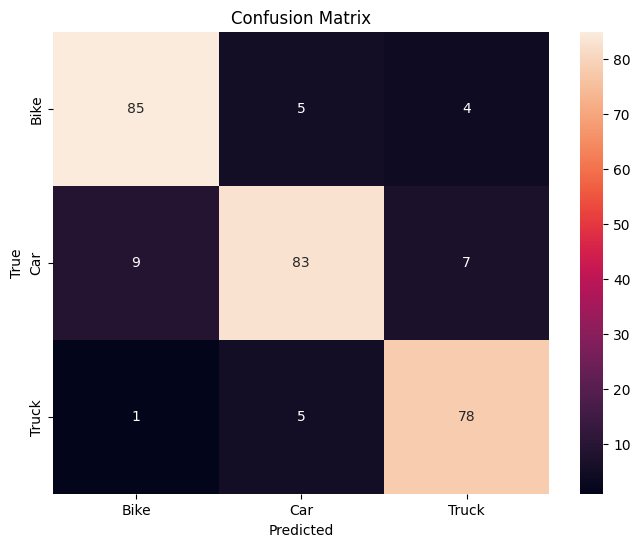

Accuracy: 88.81%
Total labels of each class: {'Bike': 94, 'Car': 99, 'Truck': 84}


In [14]:
adapt_and_evaluate(model_CNN, train_loader, test_loader)

              precision    recall  f1-score   support

        Bike       0.67      0.70      0.68        94
         Car       0.57      0.57      0.57        99
       Truck       0.53      0.50      0.51        84

    accuracy                           0.59       277
   macro avg       0.59      0.59      0.59       277
weighted avg       0.59      0.59      0.59       277



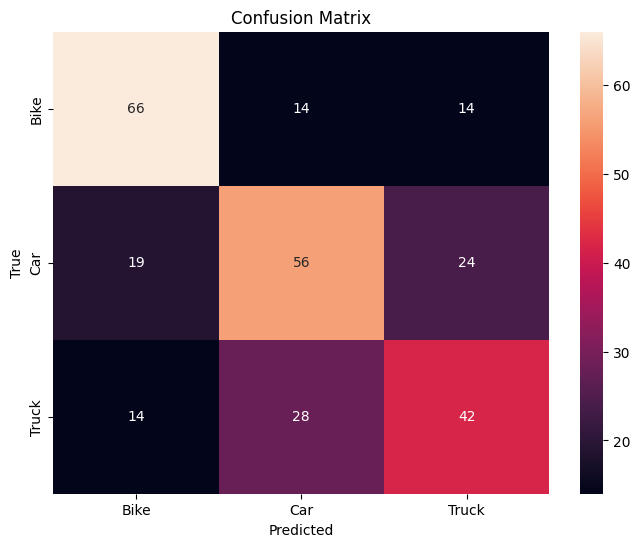

Accuracy: 59.21%
Total labels of each class: {'Bike': 94, 'Car': 99, 'Truck': 84}


In [15]:
adapt_and_evaluate(model_NN, train_loader, test_loader)

EVALUATION OF THE PERFORMANCE OF THE NEURAL NETWORK WITHOUT ADAPTATION

In [20]:
def evaluation_without_adaptation(model):
    dataset_folder_test = 'test'
    img_size = (64, 64) 
    images_test, labels_test = load_images_and_labels(dataset_folder_test, img_size)
    labels_test = np.array([label_to_index[label] for label in labels_test])
    test_loader = create_data_loader(images_test, labels_test)
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for x,y in test_loader:
            pred = model(x)
            correct_predictions += (pred.argmax(dim=1) == y).sum().item()
            total_predictions += y.size(0)

    # Calcola l'accuratezza
    accuracy = correct_predictions / total_predictions * 100
    return accuracy

In [17]:
evaluation_without_adaptation(model_CNN)

72.22222222222221

In [18]:
evaluation_without_adaptation(model_NN)

38.88888888888889

SOME IMAGES FROM THE TEST SET

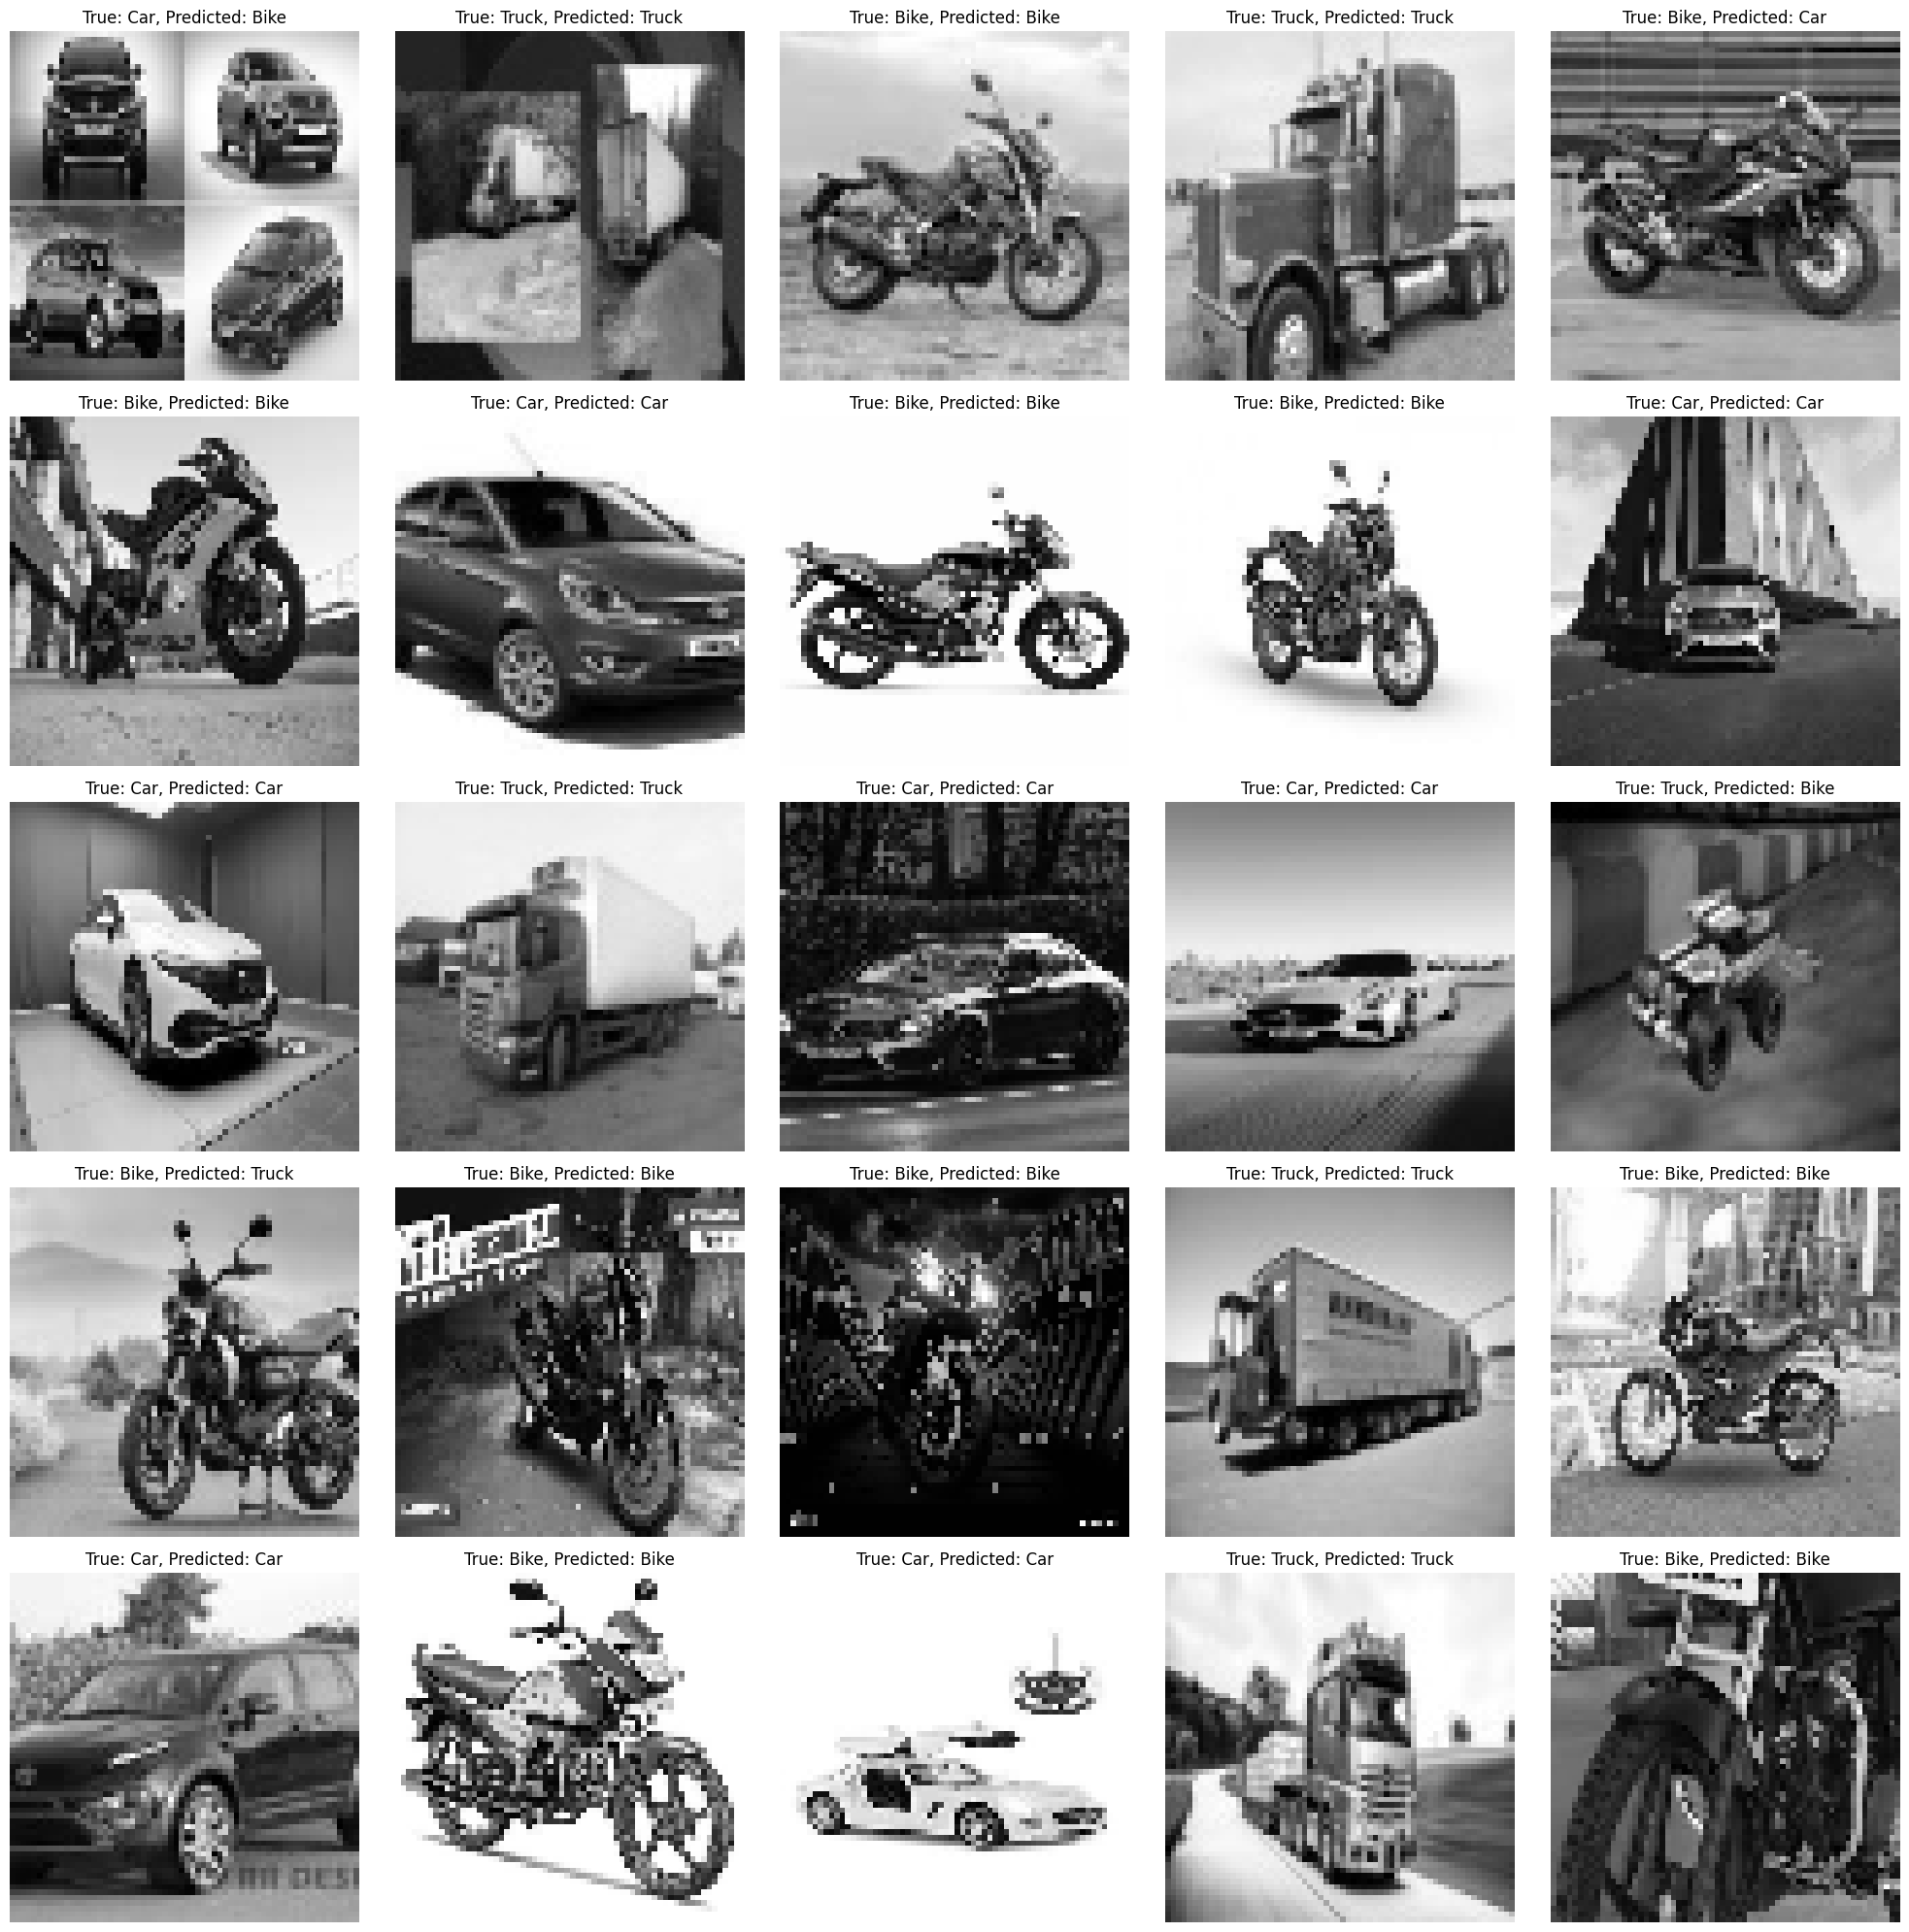

In [19]:
# Function to randomly display a specified number of predicted images
def show_random_predictions(model, test_loader, num_images=25):
    model.eval()
    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    axs = axs.flatten()
    
    class_names = label_encoder.classes_  # Use the label names from the label encoder
    displayed_images = 0

    # Collect all predictions
    all_images = []
    all_preds = []
    all_true_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x.to(device))
            all_images.extend(x.cpu().numpy())
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_true_labels.extend(y.cpu().numpy())
    
    # Shuffle the indices to select random images
    indices = list(range(len(all_images)))
    random.shuffle(indices)
    
    for i in range(num_images):
        idx = indices[i]
        img = all_images[idx].reshape(64, 64)
        true_label = all_true_labels[idx]
        predicted_label = all_preds[idx]
        
        # Display the image
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f"True: {class_names[true_label]}, Predicted: {class_names[predicted_label]}")
        axs[i].axis('off')
        
    plt.tight_layout()
    plt.show()

# Call the function to display random predictions
show_random_predictions(model_CNN, test_loader)

In [11]:
torch.save(model.state_dict(), 'model_CNN_50_epochs.pth')

In [24]:
torch.save(model.state_dict(), 'model_NeuralNetwork_50_epochs.pth')